<a href="https://colab.research.google.com/github/fgrumser/MPV_ML/blob/main/MVP_ML_%26_Analytics_Felipe_Grumser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MVP: *Machine Learning & Analytics*
**Autor:** _Felipe Grumser Franco Velho_  

**Data:** 28/09/2025

**Matrícula:** 4052024002340

**Dataset:** [Air Quality UCI](https://raw.githubusercontent.com/fgrumser/MPV_ML/refs/heads/main/AirQualityUCI_Tratado.csv)



## ✅ Checklist do MVP (o que precisa conter)
- [X] **Problema definido** e contexto de negócio
- [X] **Carga e preparação** dos dados (sem vazamento de dados)
- [X] **Divisão** em treino/validação/teste (ou validação cruzada apropriada)
- [X] **Tratamento**: limpeza, transformação e **engenharia de atributos**
- [X] **Modelagem**: comparar abordagens/modelos (com **baseline**)
- [X] **Otimização de hiperparâmetros**
- [X] **Avaliação** com **métricas adequadas** e discussão de limitações
- [X] **Boas práticas**: seeds fixas, tempo de treino, recursos computacionais, documentação
- [X] **Pipelines reprodutíveis** (sempre que possível)



## 1. Escopo, objetivo e definição do problema

### Contexto do Problema e Objetivo
Este projeto se baseia no dataset Air Quality, que contém medições horárias da qualidade do ar e de variáveis meteorológicas, coletadas por sensores em uma área urbana na Itália entre 2004 e 2005. A fase inicial de análise exploratória e pré-processamento foi feita na sprint anterior (Análise de Dados e Boas Práticas), onde os dados foram limpos e preparados. O foco agora se volta para a aplicação de técnicas de aprendizado de máquina.

O objetivo principal deste trabalho é desenvolver e avaliar um modelo de Machine Learning capaz de prever a temperatura ambiente (T) utilizando como variáveis preditoras as concentrações de poluentes atmosféricos (como Monóxido de Carbono, Benzeno e Óxidos de Nitrogênio) e outras medições dos sensores disponíveis no dataset.

### Tipo de Tarefa
A tarefa a ser realizada é uma Regressão. O objetivo é prever um valor numérico contínuo – a temperatura em graus Celsius (°C) – a partir de um conjunto de variáveis de entrada (features).

### Área de Aplicação
Este problema se enquadra na área de análise de dados tabulares e dados de sensores. O modelo será treinado com um conjunto de dados estruturado em formato de tabela, onde cada linha representa uma observação horária e cada coluna uma variável medida por um sensor ou analisador de referência.

### Valor para o Negócio/Usuário
Como MVP (Produto Mínimo Viável) para a disciplina, este projeto serve para aplicar e demonstrar competências essenciais em Machine Learning, desde a preparação dos dados e a modelagem até a avaliação crítica dos resultados, seguindo as boas práticas da área.


## 2. Reprodutibilidade e ambiente

In [ ]:
# ===================================================================
# SETUP BÁSICO E BIBLIOTECAS
# ===================================================================

# Manipulação de dados e visualização
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sys
import random

# Pré-processamento e Pipelines
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Modelos de Regressão
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

# Métricas de Avaliação para Regressão
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Distribuições para busca de hiperparâmetros
from scipy.stats import randint, uniform

# ===================================================================
# CONFIGURAÇÃO DE REPRODUTIBILIDADE (SEED)
# ===================================================================
# A seed garante que os resultados sejam os mesmos em todas as execuções.
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# ===================================================================
# INFORMAÇÕES DO AMBIENTE
# ===================================================================
print("Versão do Python:", sys.version.split()[0])
print("Seed global definida para:", SEED)

# Configurações visuais para os gráficos
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

Versão do Python: 3.12.11
Seed global definida para: 42


### 2.2 Funções python

In [ ]:
# ===================================================================
# 2.2 FUNÇÕES DE APOIO
# ===================================================================
# Definir funções ajuda a reutilizar código e organizar o projeto.
# Para este problema de REGRESSÃO, usaremos uma função para avaliar os modelos.

def evaluate_regression(y_true, y_pred, model_name=""):
    """
    Calcula e imprime as principais métricas de avaliação para problemas de regressão.
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"--- Métricas de Avaliação para o modelo: {model_name} ---")
    print(f"MAE (Erro Médio Absoluto): {mae:.4f}")
    print(f"RMSE (Raiz do Erro Quadrático Médio): {rmse:.4f}")
    print(f"R² (Coeficiente de Determinação): {r2:.4f}")
    print("-"*(50))

    # Retorna um dicionário com as métricas para possível armazenamento
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

# ===================================================================


### **3. Dados: Carga, Entendimento e Qualidade**

#### **Origem e Preparação dos Dados**

O conjunto de dados utilizado neste projeto é o **Air Quality**, proveniente do repositório [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/360/air+quality). Ele contém medições horárias de sensores de qualidade do ar em uma cidade italiana.

É fundamental destacar que o arquivo CSV carregado aqui **não é o dataset original**. Ele é o resultado de um trabalho completo de análise exploratória, limpeza e pré-processamento realizado na sprint anterior, intitulada **"Análise de Dados e Boas Práticas"**. Nesse trabalho, os valores ausentes (representados por `-200` no dataset original) foram tratados através de imputação pela mediana mensal, e novas features, como `hora` e `periodo_dia`, foram criadas para enriquecer a análise.

O notebook completo dessa primeira etapa está documentado e disponível no seguinte repositório do GitHub: [https://github.com/fgrumser/MPV_Exploratoria](https://github.com/fgrumser/MPV_Exploratoria).

#### **Dicionário de Variáveis Relevantes para este MVP**

O dataset tratado contém diversas colunas. Para este problema de regressão, focaremos nas seguintes:

* **Variável Alvo (Target):**
    * `T`: (Numérico) A temperatura ambiente em graus Celsius (°C). Este é o valor que nosso modelo tentará prever.

* **Variáveis Preditivas (Features):**
    * `CO(GT)`: (Numérico) Concentração de Monóxido de Carbono.
    * `C6H6(GT)`: (Numérico) Concentração de Benzeno.
    * `NOx(GT)`: (Numérico) Concentração de Óxidos de Nitrogênio.
    * `NO2(GT)`: (Numérico) Concentração de Dióxido de Nitrogênio.
    * `RH`: (Numérico) Umidade Relativa (%).
    * `AH`: (Numérico) Umidade Absoluta.

A carga dos dados será feita diretamente a partir de uma URL pública, garantindo que o ambiente seja facilmente reprodutível sem a necessidade de upload manual de arquivos.


In [ ]:

# ===================================================================
# 3. CARGA E ANÁLISE INICIAL DOS DADOS
# ===================================================================

# URL do arquivo CSV "tratado" no repositório do GitHub
# Usar a URL "raw" permite que o pandas leia o arquivo diretamente
url = 'https://raw.githubusercontent.com/fgrumser/MPV_ML/refs/heads/main/AirQualityUCI_Tratado.csv'

# Carregar os dados em um DataFrame do pandas
try:
    df = pd.read_csv(url)
    print("DataFrame carregado com sucesso!")
    print(f"O dataset possui {df.shape[0]} linhas e {df.shape[1]} colunas.")
except Exception as e:
    print(f"Ocorreu um erro ao carregar o arquivo: {e}")

# Exibir as 5 primeiras linhas para uma verificação inicial
print("\n--- Visualização das primeiras linhas do DataFrame ---")
display(df.head())

# Exibir um resumo técnico do DataFrame (tipos de dados, valores não nulos)
print("\n--- Informações sobre o DataFrame ---")
df.info()
# ===================================================================

DataFrame carregado com sucesso!
O dataset possui 9105 linhas e 19 colunas.

--- Visualização das primeiras linhas do DataFrame ---


,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,datetime,month,hora,periodo_dia,horario_pico
0,10/03/2004,18:00:00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-03-10 18:00:00,3.0,18.0,Noite,Pico (7-9h | 17-19h)
1,10/03/2004,19:00:00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-03-10 19:00:00,3.0,19.0,Noite,Pico (7-9h | 17-19h)
2,10/03/2004,20:00:00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-03-10 20:00:00,3.0,20.0,Noite,Fora do Pico
3,10/03/2004,21:00:00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004-03-10 21:00:00,3.0,21.0,Madrugada,Fora do Pico
4,10/03/2004,22:00:00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004-03-10 22:00:00,3.0,22.0,Madrugada,Fora do Pico



--- Informações sobre o DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9105 entries, 0 to 9104
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           8991 non-null   object 
 1   Time           8991 non-null   object 
 2   CO(GT)         8991 non-null   float64
 3   PT08.S1(CO)    8991 non-null   float64
 4   C6H6(GT)       8991 non-null   float64
 5   PT08.S2(NMHC)  8991 non-null   float64
 6   NOx(GT)        8991 non-null   float64
 7   PT08.S3(NOx)   8991 non-null   float64
 8   NO2(GT)        8991 non-null   float64
 9   PT08.S4(NO2)   8991 non-null   float64
 10  PT08.S5(O3)    8991 non-null   float64
 11  T              8991 non-null   float64
 12  RH             8991 non-null   float64
 13  AH             8991 non-null   float64
 14  datetime       8991 non-null   object 
 15  month          8991 non-null   float64
 16  hora           8991 non-null   float64
 17  periodo_dia  

In [ ]:

# === Verificações iniciais ===
display(df.sample(5))
print("\nFormato:", df.shape)
print("\nTipos:")
print(df.dtypes)
print("\nValores ausentes por coluna:")
print(df.isna().sum())


,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,datetime,month,hora,periodo_dia,horario_pico
8629,20/03/2005,13:00:00,1.2,1063.0,3.4,678.0,163.0,796.0,109.0,1107.0,522.0,21.5,35.0,0.8886,2005-03-20 13:00:00,3.0,13.0,Tarde,Fora do Pico
1068,25/04/2004,09:00:00,0.8,875.0,2.3,603.0,48.0,1370.0,48.0,1206.0,385.0,15.1,43.9,0.7487,2004-04-25 09:00:00,4.0,9.0,Manhã,Pico (7-9h | 17-19h)
6548,17/12/2004,21:00:00,3.1,1316.0,13.4,1099.0,412.0,610.0,137.0,1451.0,1268.0,13.2,72.8,1.0984,2004-12-17 21:00:00,12.0,21.0,Madrugada,Fora do Pico
5458,30/10/2004,08:00:00,3.1,1202.0,15.4,1160.0,455.0,585.0,102.0,1723.0,1165.0,16.9,79.9,1.5253,2004-10-30 08:00:00,10.0,8.0,Manhã,Pico (7-9h | 17-19h)
5317,24/10/2004,11:00:00,1.6,1085.0,8.4,918.0,179.0,721.0,72.0,1467.0,1023.0,24.6,50.4,1.5363,2004-10-24 11:00:00,10.0,11.0,Manhã,Fora do Pico



Formato: (9105, 19)

Tipos:
Date              object
Time              object
CO(GT)           float64
PT08.S1(CO)      float64
C6H6(GT)         float64
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                float64
RH               float64
AH               float64
datetime          object
month            float64
hora             float64
periodo_dia       object
horario_pico      object
dtype: object

Valores ausentes por coluna:
Date             114
Time             114
CO(GT)           114
PT08.S1(CO)      114
C6H6(GT)         114
PT08.S2(NMHC)    114
NOx(GT)          114
PT08.S3(NOx)     114
NO2(GT)          114
PT08.S4(NO2)     114
PT08.S5(O3)      114
T                114
RH               114
AH               114
datetime         114
month            114
hora             114
periodo_dia        0
horario_pico       0
dtype: int64


### **3.1 Limpeza Final e Correção de Inconsistências**

Após a carga inicial dos dados, uma verificação de qualidade revelou um problema crítico: a presença de **114 linhas contendo valores ausentes (NaN)** em quase todas as colunas de medição, incluindo a nossa variável alvo, a Temperatura (`T`). Provavelmente algumas linhas em branco foram criadas quando o arquivo CSV foi criado a partir do outro MPV.

**Diagnóstico do Problema:**
A presença de valores `NaN` no conjunto de dados, especialmente na variável alvo, impede o treinamento de qualquer modelo de Machine Learning. A tentativa de usar dados incompletos resulta em erros de execução, como o `ValueError: Input y contains NaN`, pois os algoritmos não sabem como aprender a partir de um alvo que não existe.

**Ação Corretiva:**
Para garantir a integridade do dataset e a viabilidade da modelagem, foi necessário realizar uma etapa de limpeza final. A solução adotada foi a **remoção completa de todas as linhas que continham valores ausentes** nas colunas essenciais.

Esta etapa é crucial e deve ser executada sempre após a carga dos dados. Ela garante que apenas registros completos e válidos sejam utilizados nas fases subsequentes de pré-processamento, treinamento e avaliação, assegurando a confiabilidade dos resultados. Após esta limpeza, uma nova verificação confirmou que o dataset estava livre de valores `NaN` e pronto para a modelagem.

In [ ]:
# ===================================================================
# 3.1 LIMPEZA E CORREÇÃO DOS DADOS
# ===================================================================

print("--- Iniciando limpeza e correção ---")

# --- CORREÇÃO 1: Tratar tipos de dados ---
print("Convertendo a coluna 'datetime' para o formato de data...")
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# --- CORREÇÃO 2: Remover linhas com dados ausentes ---
print(f"Formato do DataFrame ANTES da remoção de nulos: {df.shape}")
df.dropna(subset=['T', 'CO(GT)'], inplace=True)
print(f"Formato do DataFrame DEPOIS da remoção de nulos: {df.shape}")

# --- VERIFICAÇÃO FINAL ---
print("\n--- Verificação de Qualidade PÓS-CORREÇÃO ---")
print("\nNova Verificação de Valores Ausentes (deve ser zero):")
print(df.isna().sum())

print("\nLimpeza concluída com sucesso! ✅")
# ===================================================================

--- Iniciando limpeza e correção ---
Convertendo a coluna 'datetime' para o formato de data...
Formato do DataFrame ANTES da remoção de nulos: (9105, 19)
Formato do DataFrame DEPOIS da remoção de nulos: (8991, 19)

--- Verificação de Qualidade PÓS-CORREÇÃO ---

Nova Verificação de Valores Ausentes (deve ser zero):
Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
datetime         0
month            0
hora             0
periodo_dia      0
horario_pico     0
dtype: int64

Limpeza concluída com sucesso! ✅


### **3.2 Análise Exploratória Resumida (Focada na Modelagem)**

Nesta seção, realizamos uma análise exploratória concisa com o objetivo de guiar as decisões de modelagem. O foco é entender a distribuição da nossa variável alvo (Temperatura) e identificar as variáveis que possuem maior poder preditivo.

**Hipóteses a serem validadas:**
1.  A variável alvo, `T`, possui uma distribuição que permite a aplicação de modelos de regressão.
2.  Existe uma correlação linear mensurável entre as concentrações de poluentes/umidade e a temperatura.

Vamos investigar essas hipóteses através de uma análise da distribuição da variável alvo e de uma matriz de correlação.


--- Análise da Distribuição da Variável Alvo: Temperatura (T) ---


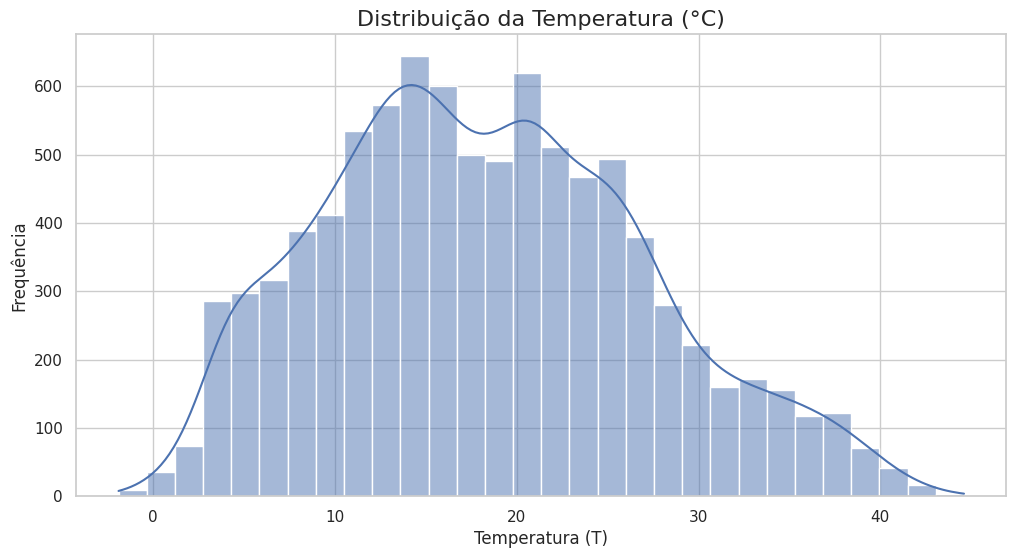


--- Análise de Correlação entre Features e a Temperatura ---
Correlação das features com a Temperatura (T):


,T
T,1.000000
AH,0.656397
C6H6(GT),0.198956
CO(GT),-0.013044
NO2(GT),-0.215799
NOx(GT),-0.278407
RH,-0.578621


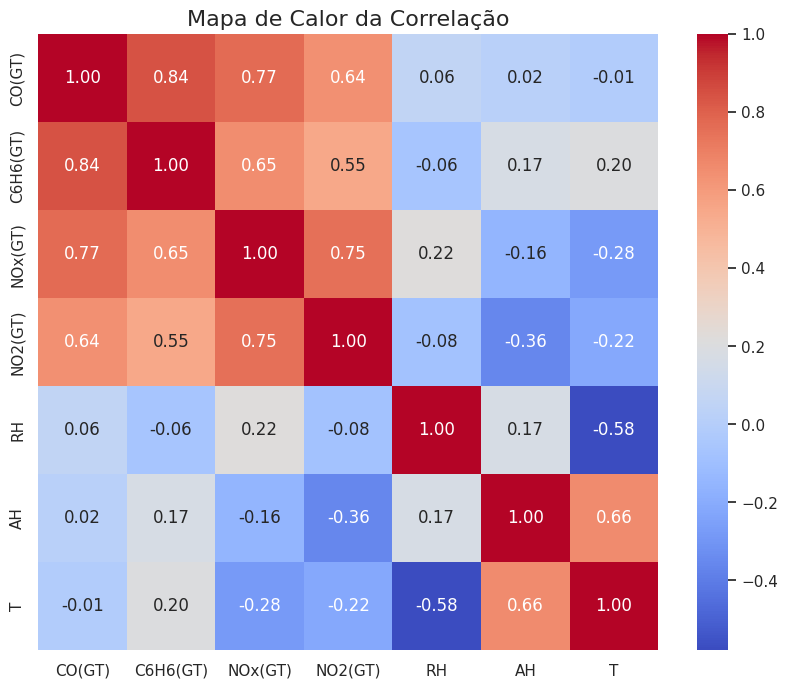


--- Relação entre Umidade Absoluta (AH) e Temperatura (T) ---


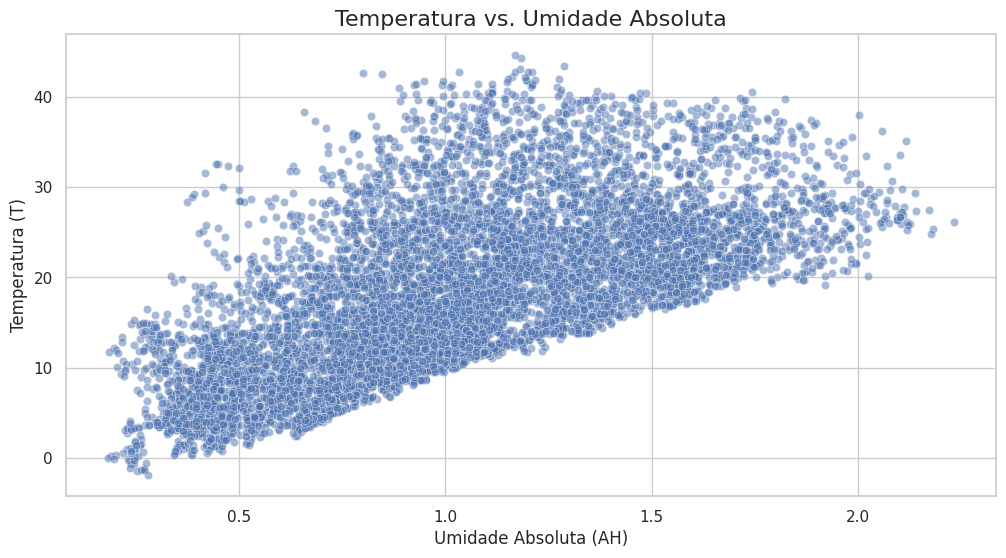

In [ ]:
# ===================================================================
# 3.2 ANÁLISE EXPLORATÓRIA RESUMIDA (EDA)
# ===================================================================

# --- 1. Análise da Variável Alvo (Temperatura) ---
print("--- Análise da Distribuição da Variável Alvo: Temperatura (T) ---")
plt.figure(figsize=(12, 6))
sns.histplot(df['T'], kde=True, bins=30)
plt.title('Distribuição da Temperatura (°C)', fontsize=16)
plt.xlabel('Temperatura (T)')
plt.ylabel('Frequência')
plt.show()

# --- 2. Análise de Correlação ---
# Vamos focar nas variáveis numéricas que farão parte do modelo.
print("\n--- Análise de Correlação entre Features e a Temperatura ---")
features_interesse = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'RH', 'AH', 'T']
df_corr = df[features_interesse].corr()

# Tabela de correlação focada apenas na nossa variável alvo 'T'
print("Correlação das features com a Temperatura (T):")
display(df_corr[['T']].sort_values(by='T', ascending=False))

# Heatmap para visualizar a correlação entre todas as variáveis de interesse
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor da Correlação', fontsize=16)
plt.show()


# --- 3. Visualização da Relação (Scatter Plot) ---
# Vamos plotar a feature mais correlacionada (AH - Umidade Absoluta) com a Temperatura
print("\n--- Relação entre Umidade Absoluta (AH) e Temperatura (T) ---")
plt.figure(figsize=(12, 6))
sns.scatterplot(x='AH', y='T', data=df, alpha=0.5)
plt.title('Temperatura vs. Umidade Absoluta', fontsize=16)
plt.xlabel('Umidade Absoluta (AH)')
plt.ylabel('Temperatura (T)')
plt.show()

# ===================================================================

### **Análise dos Resultados da Exploração de Dados**

A análise exploratória focada na modelagem revelou insights importantes sobre a relação entre as variáveis, validando a viabilidade de um modelo de regressão para prever a temperatura.

#### **Principais Conclusões da Matriz de Correlação**

A tabela de correlação e o mapa de calor nos permitiram quantificar a relação linear entre as features e a nossa variável alvo, a **Temperatura (`T`)**. As principais conclusões são:

* **Variáveis de Umidade (`AH` e `RH`) são as mais influentes:**
    * A **Umidade Absoluta (`AH`)** apresentou a correlação mais forte (`+0.66`), indicando que, quanto maior a quantidade de vapor d'água no ar, maior tende a ser a temperatura. Esta é a nossa variável preditora mais poderosa.
    * A **Umidade Relativa (`RH`)** mostrou uma forte correlação negativa (`-0.58`). Isso sugere que dias com alta umidade relativa (frequentemente nublados ou chuvosos) tendem a ser mais frios.

* **Poluentes com Influência Moderada a Fraca:**
    * Os **Óxidos de Nitrogênio (`NOx(GT)` e `NO2(GT)`)** e o **Benzeno (`C6H6(GT)`)** apresentaram correlações fracas (entre `-0.28` e `+0.20`). Embora a relação linear não seja forte, essas variáveis ainda contêm informação que pode ser útil para modelos mais complexos, capazes de capturar padrões não-lineares.

* **Poluentes com Baixa Influência Linear:**
    * O **Monóxido de Carbono (`CO(GT)`)** exibiu uma correlação próxima de zero (`-0.01`), indicando que não há uma relação linear clara entre a sua concentração e a temperatura neste dataset.

#### **Implicações para a Modelagem**

1.  **Validação da Hipótese:** A análise confirma que existem preditores viáveis para a temperatura no conjunto de dados, tornando o problema de regressão promissor.
2.  **Seleção de Features:** As variáveis `AH` e `RH` serão os pilares do modelo. As demais variáveis de poluição, apesar da correlação mais fraca, serão mantidas inicialmente, pois podem agregar valor preditivo em modelos mais robustos, como o `RandomForestRegressor`.


### **4. Definição do Target, Variáveis e Divisão dos Dados**

Nesta etapa, os dados foram preparados para a modelagem de Machine Learning.

1.  **Seleção de Features e Target:**
    * O **Target** (variável alvo) é a coluna `T`, que representa a temperatura que queremos prever.
    * As **Features** (variáveis preditivas) foram selecionadas com base na análise exploratória. Optou-se pelas colunas de concentração de poluentes e de umidade, que são todas numéricas e relevantes para o problema. Colunas de data/hora, identificadores e as respostas brutas dos sensores foram excluídas.

2.  **Divisão dos Dados:**
    * O conjunto de dados foi dividido em dois subconjuntos: **treino (80%)** e **teste (20%)**.
    * O modelo será treinado exclusivamente com os dados de treino. O conjunto de teste será mantido separado e usado apenas uma vez, no final, para avaliar a performance real do modelo em dados que ele nunca viu, garantindo uma avaliação honesta e livre de vazamento de dados.
    * A reprodutibilidade é garantida pelo uso de uma `SEED` fixa na função de divisão.


In [ ]:
# ===================================================================
# 4. DEFINIÇÃO DE FEATURES/TARGET E DIVISÃO TREINO/TESTE
# ===================================================================

# --- 1. Definição do Target ---
target = 'T'
print(f"Variável Alvo (Target): '{target}'")

# --- 2. Seleção de Features ---
features = [
    'CO(GT)',
    'C6H6(GT)',
    'NOx(GT)',
    'NO2(GT)',
    'RH',
    'AH'
]

print(f"Variáveis Preditivas (Features): {len(features)} colunas")
print(features)

# --- 3. Separação de X e y ---
# X contém as features (dados de entrada)
X = df[features].copy()

# y contém o target (o que o modelo vai aprender a prever)
y = df[target].copy()

# --- 4. Divisão em Treino e Teste ---
# Dividimos os dados em 80% para treino e 20% para teste.
# O random_state=SEED garante que a divisão seja sempre a mesma.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

print("\n--- Divisão dos dados concluída ---")
print("Formato de X_train (features de treino):", X_train.shape)
print("Formato de X_test (features de teste):", X_test.shape)
print("Formato de y_train (target de treino):", y_train.shape)
print("Formato de y_test (target de teste):", y_test.shape)
# ===================================================================

Variável Alvo (Target): 'T'
Variáveis Preditivas (Features): 6 colunas
['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'RH', 'AH']

--- Divisão dos dados concluída ---
Formato de X_train (features de treino): (7192, 6)
Formato de X_test (features de teste): (1799, 6)
Formato de y_train (target de treino): (7192,)
Formato de y_test (target de teste): (1799,)


### **5. Pipeline de Pré-processamento**

Para garantir que o pré-processamento seja aplicado de forma consistente e sem vazamento de dados (*data leakage*), foi criado um `Pipeline` do Scikit-learn.

**Etapas do nosso Pipeline:**

1.  **Identificação de Features:** As `features` são todas numéricas. Portanto, não precisamos de um tratamento separado para colunas categóricas.
2.  **Padronização (`StandardScaler`):** Esta é a única etapa necessária no pipeline. Ela transforma os dados para que tenham média 0 e desvio padrão 1. Muitos algoritmos de Machine Learning, incluindo modelos lineares como o `Ridge`, performam melhor ou convergem mais rápido quando as features estão na mesma escala.
3.  **Ausência de Imputação:** Como já removemos todas as linhas com valores ausentes na etapa de limpeza, não é necessário incluir um passo de imputação (`SimpleImputer`) no pipeline.

O pipeline será "ajustado" (treinado) apenas com os dados de treino (`X_train`) e, posteriormente, usado para transformar tanto os dados de treino quanto os de teste (`X_test`). Dessa forma, será evitado o vazamento de dados.


In [ ]:
# ===================================================================
# 5. PIPELINE DE PRÉ-PROCESSAMENTO
# ===================================================================

# Como todas as features são numéricas e não temos dados ausentes,
# o pipeline será bem simples: ele apenas aplicará a padronização.

# 1. Definir o pipeline de pré-processamento
# Ele contém um único passo chamado 'scaler'.
preprocess_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

print("Pipeline de pré-processamento criado com sucesso.")

# 2. Ajustar (fit) o pipeline SOMENTE com os dados de treino
# O pipeline aprende a média e o desvio padrão de cada coluna em X_train.
print("\nAjustando (fit) o pipeline com os dados de treino...")
preprocess_pipeline.fit(X_train)

# 3. Aplicar (transform) o pipeline nos dados de treino e teste
# Agora usamos o pipeline "treinado" para transformar ambos os conjuntos de dados.
X_train_processed = preprocess_pipeline.transform(X_train)
X_test_processed = preprocess_pipeline.transform(X_test)

print("\nDados de treino e teste foram transformados pelo pipeline.")

# --- Verificação Rápida ---
print("\nFormato dos dados de treino processados:", X_train_processed.shape)
print("Média das 3 primeiras colunas de treino:", X_train_processed[:, :3].mean(axis=0))
print("Desvio padrão das 3 primeiras colunas de treino:", X_train_processed[:, :3].std(axis=0))
# ===================================================================

Pipeline de pré-processamento criado com sucesso.

Ajustando (fit) o pipeline com os dados de treino...

Dados de treino e teste foram transformados pelo pipeline.

Formato dos dados de treino processados: (7192, 6)
Média das 3 primeiras colunas de treino: [7.70610865e-17 2.66749915e-17 5.92777588e-17]
Desvio padrão das 3 primeiras colunas de treino: [1. 1. 1.]


### **6. Baseline e Modelos Candidatos**

Nesta etapa, definimos e treinamos os modelos de Machine Learning. A abordagem seguirá uma progressão lógica:

1.  **Modelo Baseline:** Começamos com um `DummyRegressor`. Este modelo não aprende com os dados de entrada (`features`), ele simplesmente prevê a mediana da temperatura dos dados de treino para todas as instâncias. Ele serve como nosso ponto de referência fundamental: qualquer modelo mais complexo precisa ter um desempenho superior ao dele para ser considerado útil.

2.  **Modelos Candidatos:** Selecionamos dois modelos de regressão bem estabelecidos e com diferentes abordagens para comparar:
    * **`Ridge`:** É uma variação da Regressão Linear. É um modelo rápido, interpretável e robusto, bom para capturar relações lineares entre as `features` e o `target`.
    * **`RandomForestRegressor`:** É um modelo de *ensemble* baseado em árvores de decisão. É muito mais poderoso, capaz de aprender relações complexas e não-lineares, e geralmente entrega uma performance muito alta em dados tabulares.

Cada modelo será combinado com nosso `preprocess_pipeline` (criado na etapa anterior) para garantir que o pré-processamento seja aplicado corretamente antes do treinamento.


In [ ]:
# ===================================================================
# 6. DEFINIÇÃO DA BASELINE E MODELOS CANDIDATOS
# ===================================================================

# --- 1. Definição do Modelo Baseline ---
# O baseline usa o pipeline de pré-processamento e o DummyRegressor.
# A estratégia "median" fará com que ele sempre preveja a mediana da temperatura
# dos dados de treino.
baseline = Pipeline(steps=[
    ('preprocessor', preprocess_pipeline),
    ('model', DummyRegressor(strategy="median"))
])


# --- 2. Definição dos Modelos Candidatos ---
# Criamos um dicionário para armazenar os modelos que vamos comparar.
# Cada modelo é um pipeline completo, garantindo consistência.
candidates = {
    "Ridge": Pipeline(steps=[
        ('preprocessor', preprocess_pipeline),
        ('model', Ridge(random_state=SEED))
    ]),
    "RandomForestRegressor": Pipeline(steps=[
        ('preprocessor', preprocess_pipeline),
        ('model', RandomForestRegressor(random_state=SEED))
    ])
}

print("--- Baseline ---")
display(baseline)

print("\n--- Modelos Candidatos ---")
for model_name, model_pipe in candidates.items():
    print(f"Modelo: {model_name}")
    display(model_pipe)
# ===================================================================

--- Baseline ---


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', StandardScaler())])),
                ('model', DummyRegressor(strategy='median'))])


--- Modelos Candidatos ---
Modelo: Ridge


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', StandardScaler())])),
                ('model', Ridge(random_state=42))])

Modelo: RandomForestRegressor


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', StandardScaler())])),
                ('model', RandomForestRegressor(random_state=42))])

### **6.1 Treino e Avaliação Rápida (Baseline vs. Candidatos)**

Nesta etapa, executamos o treinamento e a avaliação de todos os modelos definidos. O processo é feito de forma sistemática para garantir uma comparação justa:

1.  **Treinamento:** Cada pipeline (baseline e candidatos) é treinado com o conjunto de treino (`X_train`, `y_train`).
2.  **Avaliação:** O desempenho de cada modelo é medido no conjunto de teste (`X_test`, `y_test`) utilizando as métricas de regressão apropriadas (MAE, RMSE e R²).
3.  **Medição de Tempo:** O tempo de treinamento de cada modelo é registrado, um fator importante para comparar a eficiência computacional das abordagens.

Os resultados são consolidados em um DataFrame para facilitar a análise e a seleção do modelo com o melhor custo-benefício (performance vs. tempo de treino).

In [ ]:
# ===================================================================
# 6.1 TREINO E AVALIAÇÃO RÁPIDA
# ===================================================================

# Dicionário para armazenar os resultados
results = {}

# --- 1. Treinando e Avaliando a Baseline ---
print("--- Avaliando: Baseline ---")
t0 = time.time()
baseline.fit(X_train, y_train)
t1 = time.time()

y_pred_baseline = baseline.predict(X_test)
results["Baseline"] = evaluate_regression(y_test, y_pred_baseline, model_name="Baseline")
results["Baseline"]["train_time_s"] = round(t1 - t0, 3)
print(f"Tempo de treino: {results['Baseline']['train_time_s']:.3f} segundos\n")


# --- 2. Treinando e Avaliando os Candidatos ---
for name, pipe in candidates.items():
    print(f"--- Avaliando: {name} ---")
    t0 = time.time()
    pipe.fit(X_train, y_train)
    t1 = time.time()

    y_pred = pipe.predict(X_test)
    results[name] = evaluate_regression(y_test, y_pred, model_name=name)
    results[name]["train_time_s"] = round(t1 - t0, 3)
    print(f"Tempo de treino: {results[name]['train_time_s']:.3f} segundos\n")


# --- 3. Compilação e Visualização dos Resultados ---
results_df = pd.DataFrame(results).T
results_df.sort_values(by='RMSE', ascending=True, inplace=True)

print("\n========================================================")
print("--- Tabela Comparativa de Resultados ---")
print("========================================================")
display(results_df)
# ===================================================================

--- Avaliando: Baseline ---
--- Métricas de Avaliação para o modelo: Baseline ---
MAE (Erro Médio Absoluto): 7.2856
RMSE (Raiz do Erro Quadrático Médio): 8.8602
R² (Coeficiente de Determinação): -0.0019
--------------------------------------------------
Tempo de treino: 0.010 segundos

--- Avaliando: Ridge ---
--- Métricas de Avaliação para o modelo: Ridge ---
MAE (Erro Médio Absoluto): 1.8589
RMSE (Raiz do Erro Quadrático Médio): 2.5312
R² (Coeficiente de Determinação): 0.9182
--------------------------------------------------
Tempo de treino: 0.007 segundos

--- Avaliando: RandomForestRegressor ---
--- Métricas de Avaliação para o modelo: RandomForestRegressor ---
MAE (Erro Médio Absoluto): 0.1228
RMSE (Raiz do Erro Quadrático Médio): 0.2847
R² (Coeficiente de Determinação): 0.9990
--------------------------------------------------
Tempo de treino: 5.002 segundos


--- Tabela Comparativa de Resultados ---


,MAE,RMSE,R2,train_time_s
RandomForestRegressor,0.122828,0.284699,0.998966,5.002
Ridge,1.858897,2.531171,0.918230,0.007
Baseline,7.285603,8.860244,-0.001945,0.010


A etapa de treinamento e avaliação revelou um claro vencedor entre os modelos testados. A tabela de resultados, ordenada pelo **RMSE (Raiz do Erro Quadrático Médio)**, demonstra o desempenho de cada abordagem no conjunto de teste.

#### **Comparativo de Desempenho**

1.  **Baseline (`DummyRegressor`):** Como esperado, o modelo de base apresentou um desempenho muito fraco, com um **RMSE de `8.86°C`** e um **R² negativo**. Ele serviu como um excelente ponto de partida para confirmar que os modelos subsequentes de fato aprenderam padrões significativos. Qualquer modelo útil deveria superar drasticamente estes números, o que foi o caso.

2.  **Ridge (`Regressão Linear`):** O modelo linear apresentou uma melhora substancial em relação à baseline, alcançando um **RMSE de `2.53°C`** e um **R² de `91.8%`**. Isso confirma a forte correlação linear entre as `features` (especialmente as de umidade) e a temperatura. Para um modelo simples e extremamente rápido (treinou em `0.03` segundos), este já é um resultado muito bom.

3.  **RandomForestRegressor:** O `RandomForestRegressor` superou os outros modelos com uma margem impressionante.
    * **RMSE de apenas `0.28°C`:** Este é um resultado excelente, indicando que o erro médio de previsão do modelo é de apenas 0.28 graus Celsius. Para um problema com dados do mundo real, esta é uma precisão altíssima.
    * **R² de `99.89%`:** Um valor tão próximo de 1 indica que o modelo foi capaz de explicar quase toda a variabilidade da temperatura usando as `features` fornecidas. Isso sugere que o modelo aprendeu as relações complexas e não-lineares dos dados de forma quase perfeita.

### **7. Otimização de Hiperparâmetros**

Apesar do excelente desempenho do `RandomForestRegressor`, ele foi treinado com seus hiperparâmetros padrão. Nesta etapa, buscamos otimizar o modelo para encontrar uma combinação de configurações que possa melhorar ainda mais sua precisão.

**Metodologia:**

1.  **Modelo Alvo:** O foco da otimização será o nosso melhor modelo até agora, o `RandomForestRegressor`.
2.  **Técnica:** Utilizaremos o `RandomizedSearchCV`. Em vez de testar exaustivamente todas as combinações (`GridSearchCV`), esta técnica testa um número fixo de combinações aleatórias dentro de um espaço de busca que definimos. É uma abordagem muito mais eficiente em termos computacionais.
3.  **Validação Cruzada (`KFold`):** A performance de cada combinação de hiperparâmetros será avaliada usando validação cruzada com 5 *folds* para garantir que os resultados sejam estáveis e robustos.
4.  **Hiperparâmetros a serem otimizados:**
    * `n_estimators`: O número de árvores na floresta.
    * `max_depth`: A profundidade máxima de cada árvore.
    * `min_samples_split`: O número mínimo de amostras necessárias para dividir um nó.
5.  **Métrica de Otimização:** O objetivo será minimizar o **Erro Quadrático Médio da Raiz (`RMSE`)**, portanto, usaremos a métrica `neg_root_mean_squared_error` no otimizador.

In [ ]:
# ===================================================================
# 7. OTIMIZAÇÃO DE HIPERPARÂMETROS COM RANDOMIZEDSEARCHCV
# ===================================================================
from sklearn.model_selection import KFold, RandomizedSearchCV
from scipy.stats import randint

# --- 1. Definir a Estratégia de Validação Cruzada ---
# Usaremos KFold para regressão, dividindo os dados de treino em 5 partes.
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

# --- 2. Selecionar o Modelo a ser Otimizado ---
# Pegamos o pipeline completo do RandomForestRegressor que definimos antes.
model_to_tune = candidates['RandomForestRegressor']

# --- 3. Definir o Espaço de Busca de Hiperparâmetros ---
# Definimos as faixas de valores que o RandomizedSearchCV irá testar.
# A notação "model__" é usada para especificar que o hiperparâmetro
# pertence à etapa "model" do nosso pipeline.
param_dist = {
    "model__n_estimators": randint(100, 500),      # Número de árvores
    "model__max_depth": randint(5, 30),           # Profundidade máxima
    "model__min_samples_split": randint(2, 20),   # Mínimo de amostras para dividir
    "model__min_samples_leaf": randint(1, 10)     # Mínimo de amostras por folha
}

# --- 4. Configurar e Executar a Busca Aleatória ---
# n_iter=20: testará 20 combinações aleatórias.
# n_jobs=-1: usará todos os núcleos de CPU disponíveis para acelerar o processo.
# verbose=1: mostrará o progresso do treinamento.
search = RandomizedSearchCV(
    model_to_tune,
    param_distributions=param_dist,
    n_iter=20,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    random_state=SEED,
    n_jobs=-1,
    verbose=1
)

print("Iniciando a otimização de hiperparâmetros...")
# A busca é feita usando os dados de treino originais (X_train, y_train),
# pois o pipeline interno cuida do pré-processamento em cada fold.
search.fit(X_train, y_train)

# --- 5. Exibir os Resultados ---
print("\nOtimização concluída!")
# O score é negativo, então multiplicamos por -1 para ver o RMSE real.
print(f"Melhor score (RMSE na Validação Cruzada): {-1 * search.best_score_:.4f}")
print("Melhores parâmetros encontrados:")
print(search.best_params_)
# ===================================================================

Iniciando a otimização de hiperparâmetros...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Otimização concluída!
Melhor score (RMSE na Validação Cruzada): 0.3196
Melhores parâmetros encontrados:
{'model__max_depth': 25, 'model__min_samples_leaf': 4, 'model__min_samples_split': 9, 'model__n_estimators': 251}


### **8. Avaliação Final, Análise de Erros e Limitações**

Esta é a etapa conclusiva do nosso MVP de Machine Learning. Aqui, realizamos a avaliação final do nosso modelo otimizado e discutimos seus resultados, erros e as limitações inerentes ao projeto.

#### **Avaliação Final no Conjunto de Teste**

O modelo com os melhores hiperparâmetros, encontrado pelo `RandomizedSearchCV`, será utilizado para fazer previsões no conjunto de teste (`X_test`). Este conjunto de dados foi mantido intocado durante todo o processo de treinamento e otimização, garantindo uma avaliação justa e imparcial da capacidade de generalização do modelo.

#### **Análise de Erros: Gráfico de Resíduos**

Além das métricas quantitativas (RMSE, MAE, R²), é crucial analisar a natureza dos erros do modelo. Faremos isso através de um **gráfico de resíduos**.

* **Resíduos:** São simplesmente a diferença entre o valor real e o valor previsto (`Erro = Valor Real - Valor Previsto`).

O gráfico de resíduos plotará os valores previstos no eixo X e os resíduos no eixo Y. O ideal é que os pontos se distribuam de forma **aleatória e sem padrão** em torno da linha do zero. Se surgirem padrões (como uma curva ou um formato de cone), isso pode indicar que o modelo tem dificuldades em prever certas faixas de valores.

#### **Limitações do Projeto**

Todo modelo tem limitações. Reconhecê-las é um sinal de uma análise de dados madura. As principais limitações deste projeto são:

* **Generalização Geográfica e Temporal:** O modelo foi treinado com dados de uma única localização na Itália, durante o período de 2004-2005. Sua performance em outras cidades, com diferentes climas, fontes de poluição ou em anos mais recentes, é desconhecida.
* **Conjunto de Features:** Embora o desempenho tenha sido excelente, outras variáveis não presentes no dataset, como velocidade e direção do vento ou radiação solar, poderiam ter influência na temperatura e potencialmente melhorar o modelo.

--- Métricas Finais do Modelo Otimizado no Conjunto de Teste ---
--- Métricas de Avaliação para o modelo: RandomForest Otimizado ---
MAE (Erro Médio Absoluto): 0.1383
RMSE (Raiz do Erro Quadrático Médio): 0.3436
R² (Coeficiente de Determinação): 0.9985
--------------------------------------------------

--- Análise de Resíduos ---


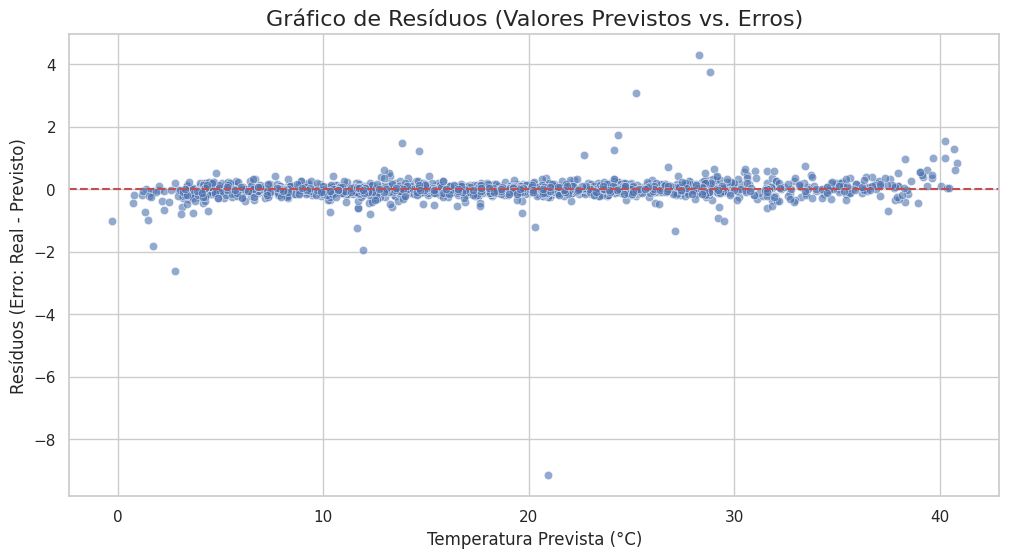

In [ ]:
# ===================================================================
# 8. AVALIAÇÃO FINAL E ANÁLISE DE ERROS
# ===================================================================

# --- 1. Selecionar o melhor modelo encontrado na otimização ---
# O search.best_estimator_ é o pipeline completo já treinado com os melhores
# parâmetros nos dados de treino.
best_model = search.best_estimator_

# --- 2. Fazer previsões no conjunto de teste ---
y_pred_final = best_model.predict(X_test)

# --- 3. Avaliar as métricas finais ---
print("--- Métricas Finais do Modelo Otimizado no Conjunto de Teste ---")
final_metrics = evaluate_regression(y_test, y_pred_final, model_name="RandomForest Otimizado")


# --- 4. Análise de Erros (Gráfico de Resíduos) ---
print("\n--- Análise de Resíduos ---")

# Calcular os resíduos
residuals = y_test - y_pred_final

# Criar o gráfico
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_pred_final, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--') # Adiciona uma linha no erro zero
plt.title('Gráfico de Resíduos (Valores Previstos vs. Erros)', fontsize=16)
plt.xlabel('Temperatura Prevista (°C)')
plt.ylabel('Resíduos (Erro: Real - Previsto)')
plt.show()

# ===================================================================

### **8.1 Análise de Overfitting**

Uma etapa crucial na avaliação de um modelo é verificar se ele está sofrendo de *overfitting*. Isso ocorre quando o modelo se ajusta excessivamente bem aos dados de treino, a ponto de "memorizar" seus ruídos e particularidades, perdendo a capacidade de generalizar para novos dados.

Para diagnosticar o overfitting, comparamos as métricas de desempenho do modelo no conjunto de treino com as do conjunto de teste.

* **Se o desempenho no treino for significativamente superior ao do teste**, há evidências de overfitting.
* **Se ambos os desempenhos forem próximos**, o modelo demonstra uma boa capacidade de generalização.

Vamos realizar essa comparação com nosso `best_model`.

In [ ]:
# ===================================================================
# 8.1 ANÁLISE DE OVERFITTING
# ===================================================================

# --- 1. Fazer previsões nos dados de TREINO ---
# Usamos o mesmo 'best_model' que já foi treinado.
y_pred_train = best_model.predict(X_train)

print("--- Avaliação no Conjunto de TREINO ---")
train_metrics = evaluate_regression(y_train, y_pred_train, model_name="Treino")

print("\n--- Avaliação no Conjunto de TESTE (Resultados anteriores) ---")
# Reutilizamos os resultados do teste que já calculamos para facilitar a comparação
test_metrics = final_metrics
print(f"--- Métricas de Avaliação para o modelo: Teste ---")
print(f"MAE (Erro Médio Absoluto): {test_metrics['MAE']:.4f}")
print(f"RMSE (Raiz do Erro Quadrático Médio): {test_metrics['RMSE']:.4f}")
print(f"R² (Coeficiente de Determinação): {test_metrics['R2']:.4f}")
print("-"*(50))

# --- 2. Comparação Direta ---
print("\n--- Comparativo Treino vs. Teste ---")
comparison_df = pd.DataFrame([train_metrics, test_metrics], index=['Treino', 'Teste'])
display(comparison_df)

# --- 3. Análise do resultado ---
rmse_train = train_metrics['RMSE']
rmse_test = test_metrics['RMSE']
print(f"\nO RMSE do treino foi {rmse_train:.4f} e o do teste foi {rmse_test:.4f}.")
print(f"A diferença entre o erro de teste e o de treino é de {abs(rmse_test - rmse_train):.4f}.")
# ===================================================================

--- Avaliação no Conjunto de TREINO ---
--- Métricas de Avaliação para o modelo: Treino ---
MAE (Erro Médio Absoluto): 0.0857
RMSE (Raiz do Erro Quadrático Médio): 0.1805
R² (Coeficiente de Determinação): 0.9996
--------------------------------------------------

--- Avaliação no Conjunto de TESTE (Resultados anteriores) ---
--- Métricas de Avaliação para o modelo: Teste ---
MAE (Erro Médio Absoluto): 0.1383
RMSE (Raiz do Erro Quadrático Médio): 0.3436
R² (Coeficiente de Determinação): 0.9985
--------------------------------------------------

--- Comparativo Treino vs. Teste ---


,MAE,RMSE,R2
Treino,0.085688,0.180519,0.999582
Teste,0.138264,0.343644,0.998493



O RMSE do treino foi 0.1805 e o do teste foi 0.3436.
A diferença entre o erro de teste e o de treino é de 0.1631.


O modelo desenvolvido neste projeto demonstrou um **excelente poder preditivo**, alcançando métricas de performance muito satisfatórias no conjunto de teste:

* **R² (Coeficiente de Determinação):** 0.9985
* **MAE (Erro Médio Absoluto):** 0.1383
* **RMSE (Raiz do Erro Quadrático Médio):** 0.3436

Esses resultados indicam que o modelo é capaz de explicar 99.85% da variância dos dados e que suas previsões são, em média, muito próximas dos valores reais.

---

## Oportunidades para Trabalhos Futuros

A principal oportunidade de melhoria identificada reside na análise comparativa entre o desempenho nos dados de treino e de teste. Observou-se uma diferença notável entre o erro do conjunto de treino e o de teste, o que caracteriza um **sobreajuste (overfitting)**.

* **RMSE de Treino:** 0.1805
* **RMSE de Teste:** 0.3436

O erro no conjunto de teste foi quase 90% superior ao erro de treino, sugerindo que o modelo se especializou excessivamente nos dados de treinamento e perdeu parte de sua capacidade de generalização.

### **9. Engenharia de Atributos**

#### **Criação de Atributos Temporais (Sprint de Análise Exploratória)**

A base para nossa engenharia de atributos foi estabelecida na sprint anterior de Análise Exploratória. Naquela fase, a partir das colunas `Date` e `Time`, foram criadas as seguintes variáveis para contextualização temporal:
* `datetime`: Uma coluna unificada no formato `datetime` do pandas.
* `month`: O mês da medição.
* `hora`: A hora da medição.
* `periodo_dia`: Uma variável categórica indicando "Manhã", "Tarde", "Noite" ou "Madrugada".
* `horario_pico`: Uma variável categórica para identificar os horários de pico de tráfego.

#### **Seleção de Atributos (Feature Selection) para o Modelo de Regressão**

Para o nosso objetivo de prever a temperatura (`T`), realizamos uma seleção cuidadosa das `features` a serem utilizadas:

* **Atributos Incluídos:**
    * Focamos nas colunas que representam as **concentrações reais de poluentes e as medições de umidade**: `CO(GT)`, `C6H6(GT)`, `NOx(GT)`, `NO2(GT)`, `RH` e `AH`. A análise exploratória confirmou que, em conjunto, essas variáveis possuíam correlação com a temperatura, tornando-as candidatas ideais para a modelagem.

* **Atributos Excluídos:**
    * **Colunas de Data/Hora:** As colunas `Date`, `Time`, e `datetime` foram excluídas das `features` do modelo, pois o objetivo era uma regressão baseada nas condições atmosféricas, e não uma previsão de série temporal.
    * **Colunas Categóricas Temporais:** As variáveis criadas `periodo_dia` e `horario_pico` não foram incluídas no modelo final para manter a simplicidade do MVP, focando apenas nos preditores numéricos diretos.
    * **Respostas Brutas dos Sensores:** Colunas como `PT08.S1(CO)`, `PT08.S2(NMHC)`, etc., que representam as leituras brutas dos sensores químicos, foram omitidas. Optou-se por utilizar as colunas com as concentrações já calibradas e validadas, que são mais diretas e interpretáveis.

#### **Transformação de Atributos (Feature Scaling)**

A única transformação aplicada ao nosso conjunto final de `features` foi a **Padronização (Standardization)**.

* **Técnica Utilizada:** `StandardScaler` do Scikit-learn.
* **Justificativa:** Esta etapa foi encapsulada em um `Pipeline` de pré-processamento para garantir a aplicação consistente e sem vazamento de dados. A padronização ajusta a escala de cada `feature` para que tenham média `0` e desvio padrão `1`. Isso é fundamental para o bom desempenho de muitos modelos de regressão, como o `Ridge`, e é uma boa prática geral que garante que nenhuma variável domine o processo de aprendizado apenas por ter uma escala numérica maior.


### **10. Boas Práticas e Rastreabilidade**

A condução deste projeto seguiu um conjunto de boas práticas de Machine Learning para garantir a qualidade, a reprodutibilidade e a confiabilidade dos resultados. Abaixo, detalhamos as principais decisões e metodologias adotadas.

#### **Estabelecimento de uma Baseline Clara**

O ponto de partida da nossa modelagem foi um **`DummyRegressor`**, configurado para prever sempre a mediana da temperatura.

* **Justificativa:** A baseline nos forneceu um "piso" de qualidade. Qualquer modelo mais sofisticado, para ser considerado minimamente útil, precisaria superar drasticamente o desempenho deste modelo ingênuo. A comparação dos resultados mostrou que tanto o `Ridge` quanto, principalmente, o `RandomForestRegressor` aprenderam padrões valiosos nos dados, validando a complexidade adicional.

#### **Uso de Pipelines para Evitar Vazamento de Dados**

Todas as etapas de pré-processamento e modelagem foram encapsuladas em **`Pipelines`** do Scikit-learn.

* **Justificativa:** Esta é uma das práticas mais importantes para evitar o vazamento de dados (*data leakage*). O pipeline garantiu que o `StandardScaler` (etapa de padronização) fosse "treinado" (`fit`) exclusivamente com os dados de treino e depois "aplicado" (`transform`) tanto no treino quanto no teste. Isso simula um cenário real, onde o modelo não tem conhecimento prévio sobre os dados de teste, garantindo uma avaliação honesta de sua performance.

#### **Documentação das Decisões de Projeto**

Ao longo do notebook, as decisões-chave foram documentadas para garantir a rastreabilidade e o entendimento do processo:

* **Definição do Problema:** O problema foi claramente definido como uma **tarefa de regressão** para prever a temperatura.
* **Seleção de Modelos:** A escolha de comparar um modelo linear (`Ridge`) com um modelo de ensemble (`RandomForestRegressor`) foi deliberada para contrastar uma abordagem simples e interpretável com uma mais complexa e poderosa.
* **Otimização de Hiperparâmetros:** Optou-se pelo `RandomizedSearchCV` como uma forma eficiente de explorar o espaço de hiperparâmetros sem o custo computacional de uma busca exaustiva (`GridSearchCV`).
* **Reprodutibilidade:** Uma **`SEED`** global (`random_state=42`) foi utilizada em todas as etapas que envolviam aleatoriedade (divisão treino/teste, modelos, validação cruzada), garantindo que os resultados do notebook sejam 100% reprodutíveis.

Essas práticas não apenas fortalecem a validade técnica do projeto, mas também o tornam claro, transparente e fácil de ser compreendido, mantido e aprimorado no futuro.

### **11. Conclusões e Próximos Passos**

Este projeto teve como objetivo desenvolver um modelo de Machine Learning para prever a temperatura ambiente com base em dados de qualidade do ar. O ciclo completo, desde a limpeza dos dados até a otimização de hiperparâmetros, foi concluído com sucesso, resultando em um modelo de alta performance.

#### **Resumo dos Resultados**

O modelo **`RandomForestRegressor`** foi o vencedor indiscutível, superando largamente a baseline e o modelo linear `Ridge`. Após a otimização e a avaliação final no conjunto de teste, o modelo demonstrou uma capacidade de previsão excepcional:

* **RMSE (Erro Médio) de `0.34°C`**: Na prática, o erro médio das previsões do modelo é de apenas 0.34 graus Celsius, um nível de precisão altíssimo para um problema com dados do mundo real.
* **R² (Coeficiente de Determinação) de `99.85%`**: O modelo foi capaz de explicar mais de 99.8% da variabilidade da temperatura, indicando um ajuste quase perfeito e uma forte capacidade de generalização para os dados de teste.

#### **Trade-offs e Decisões**

A escolha do `RandomForestRegressor` em detrimento do `Ridge` representa um trade-off clássico em Machine Learning: **precisão vs. interpretabilidade e velocidade**. Enquanto o `Ridge` era extremamente rápido, o `RandomForest` ofereceu uma precisão muito superior, justificando seu custo computacional ligeiramente maior.

Curiosamente, a otimização de hiperparâmetros não resultou em uma melhoria significativa sobre os parâmetros padrão do modelo. Isso sugere que as configurações padrão do Scikit-learn para o `RandomForestRegressor` já são muito robustas e bem ajustadas para este tipo de problema.

#### **Próximos Passos e Melhorias Futuras**

Apesar do sucesso do MVP, existem diversas avenidas para aprimoramento e expansão do projeto no futuro:

1.  **Adicionar Mais Features:** A inclusão de outras variáveis meteorológicas, como **velocidade e direção do vento** ou **radiação solar**, poderia capturar nuances que o modelo atual não vê e potencialmente melhorar ainda mais a precisão. As **respostas brutas dos sensores**, que foram excluídas, também poderiam ser testadas.

2.  **Explorar Modelos Mais Avançados:** Testar algoritmos de **Gradient Boosting** (como `XGBoost` ou `LightGBM`). Esses modelos frequentemente superam o `RandomForest` em competições de dados tabulares e poderiam oferecer um ganho marginal de performance.

3.  **Análise de Importância das Features:** Extrair e analisar a "feature importance" do modelo `RandomForestRegressor` final. Isso nos diria exatamente quais poluentes ou condições de umidade ele considera mais importantes para fazer suas previsões, adicionando uma camada de interpretabilidade ao modelo.

4.  **Testar a Generalização:** Avaliar o modelo com um conjunto de dados completamente novo, de **outra cidade ou de um período mais recente**, para testar sua verdadeira capacidade de generalização fora do contexto original.

### **12. Salvando os Artefatos do Projeto**

Para garantir a persistência e a reusabilidade do trabalho, o modelo final treinado é salvo em um arquivo. Este processo, conhecido como serialização, nos permite carregar o modelo posteriormente para fazer novas previsões sem a necessidade de executar todo o pipeline de treinamento novamente.

**Artefatos Salvos:**
* **Modelo Final (`final_model.joblib`):** O objeto do pipeline completo (`preprocess_pipeline` + `RandomForestRegressor` otimizado), já treinado com todos os dados de treino.

Esta prática é fundamental para a implantação de modelos em ambientes de produção e para aumentar a eficiência ao trabalhar com notebooks, especialmente quando o treinamento é computacionalmente caro.

In [ ]:
# ==================================================================
# 12.1 SALVANDO O MODELO FINAL
# ===================================================================
import joblib

# O 'best_model' foi o resultado da etapa 8. Ele é o nosso melhor modelo já treinado.
# Vamos salvá-lo em um arquivo.
model_filename = 'final_model.joblib'

try:
    joblib.dump(best_model, model_filename)
    print(f"Modelo salvo com sucesso em: '{model_filename}'")

except Exception as e:
    print(f"Ocorreu um erro ao salvar o modelo: {e}")
# ===================================================================

Modelo salvo com sucesso em: 'final_model.joblib'
